In [265]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')       


## Exploratory analysis of dataset GSE86956 obtained from Gene Expression Omnibus (GEO)

The data discussed in this publication have been deposited in NCBI's Gene Expression Omnibus and are accessible through GEO Series accession number GSE86956 at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE86956

### Goals of this report
This report aims to conduct an exploratory analysis of the RNA-seq data generated by this study using an [RNA-seq pipeline](https://f1000researchdata.s3.amazonaws.com/manuscripts/9804/8fa2f4e7-d0f3-488c-85f1-0b3a9816faef_9110_-_avi_maaayn.pdf?doi=10.12688/f1000research.9110.1) developed by [the Ma'ayan Lab](http://labs.icahn.mssm.edu/maayanlab/) at [the Icahn School of Medicine at Mount Sinai](http://icahn.mssm.edu/). This [Jupyter Notebook](http://jupyter.org/) was automatically generated <a href='#Citations'>[1]</a>.


### Analysis Overview
#### 1.  <a href='#Dimensionality Reduction'>Dimensionality Reduction</a> 
Dimensionality reduction helps analyze and visualize multidimensional data by reducing the data to 3D space. Principal component analysis (PCA) was applied to the data in this analysis.
#### 2.  <a href='#Interactive Heatmap'>Interactive Heatmap</a>
[Clustergrammer](http://clustergrammer.readthedocs.io/clustergrammer_widget.html) is an interactive tool that can be used to visualize a wide range of biological data. It is particularly useful for gene expression data. Clusters of upregulated and downregulated genes for the groups are clearly visible, which simplifies further analysis and comparisons between differential expression signatures.
#### 3.  <a href='#Differential Expression Analysis'>Differential Expression Analysis</a>
This analysis helps to identify genes that show differences in expression as compared to control. This information can be used to obtain a deeper understanding of the molecular mechanisms of biological processes.
#### 4.  <a href='#Gene Set Enrichment Analysis'>Gene Set Enrichment Analysis</a>
Gene Set Enrichment Analysis uses the upregulated and downregulated genes identified in differential expression analysis to provide valuable insight into the underlying mechanisms of biological processes.
#### 5.  <a href='#Small Molecule Predictions'>Small Molecule Predictions</a>
This analysis produces a set of small molecules that are predicted either mimic or reverse the expression profiles observed in the experiment.



<a id='Dimensionality Reduction'></a>

## 1. Dimensionality Reduction

### Principal Component Analysis (PCA)
PCA was used to reduce the data to three-dimensional space. Counts per million (CPM) and z-score normalization methods were used before applying PCA. A PCA plot is expected to show clusters of samples relevant to experimental groups <a href='#Citations'>[2]</a>.


In [266]:
%%capture

# Initialize Plotly and R magic
%load_ext rpy2.ipython

%R require(limma)
%R require(edgeR)
%R require(ggpot)
%R require(gridExtra)
from plotly.offline import init_notebook_mode
init_notebook_mode()

import sys
import xlrd
sys.path.append('scripts')
sys.path.append('gloriascripts')
import pandas as pd
import archs4
import numpy as np 


In [267]:
import xlrd

In [268]:
data=xlrd.open_workbook('sample_data.xlsx')

In [269]:
data_sheet=data.sheet_by_index(0)
row=data_sheet.row(1)

gse=data_sheet.cell(1,0).value
gse=gse.encode('ascii','ignore')

platform=data_sheet.cell(1,1).value
platform=platform.encode('ascii','ignore')
sample_id=gse+"_"+platform



In [270]:
rawcount_dataframe,sample_title_dict,treatment_dataframe = archs4.fetch_dataset('GSE86956_GPL16791')

In [271]:
rawcount_dataframe=rawcount_dataframe.drop(rawcount_dataframe.index[rawcount_dataframe.mean(axis=1)<=rawcount_dataframe.shape[1]])
rawcount_dataframe_original=rawcount_dataframe.copy(deep=True)

group_dataframe=pd.DataFrame()

group_dataframe_list=sample_title_dict.values()

group_dataframe['treatment']=pd.Series(sample_title_dict.get(v) for v in rawcount_dataframe_original.columns)
group_dataframe['treatment']=pd.Series(v.split(' (GSM')[0] for v in group_dataframe['treatment'])
treatment_dataframe.columns=['treatment']

group_dataframe.index=treatment_dataframe['treatment']
treatment_dataframe.index=group_dataframe['treatment']

rawcount_dataframe.columns=group_dataframe['treatment']


norm_dataframe=pd.DataFrame()
norm_dataframe=rawcount_dataframe.copy(deep=True)



#cpm normalizing the columns

cpm_factors=rawcount_dataframe.sum(axis=0)/1000000
for i in range(0,rawcount_dataframe.shape[1]):
    norm_dataframe.iloc[:,i]=rawcount_dataframe.iloc[:,i]/cpm_factors[i]

#z score normalize the rows

from scipy import stats
for rows in range(0,rawcount_dataframe.shape[0]):
    norm_dataframe.iloc[rows,:] = stats.zscore(rawcount_dataframe.iloc[rows,:])

from sklearn.decomposition import PCA
pca_3=PCA(n_components=3)
pca_3.fit_transform(norm_dataframe)

import plot_3d_scatter
fig=plot_3d_scatter.plot_3d_scatter(pca_3.components_[0],pca_3.components_[1],pca_3.components_[2], size=5, color_by=treatment_dataframe['treatment'].tolist(),
xlab= 'PC1 ({:.2%} of variance explained)'.format(pca_3.explained_variance_ratio_[0]),
ylab= 'PC2 ({:.2%} of variance explained)'.format(pca_3.explained_variance_ratio_[1]),
zlab= 'PC3 ({:.2%}of variance explained)'.format(pca_3.explained_variance_ratio_[2]))




In [272]:

%Rpush rawcount_dataframe
%Rpush treatment_dataframe
%Rpush group_dataframe
%R design<-model.matrix(~1+treatment, group_dataframe)
%R voom_dataframe<-voom(rawcount_dataframe,plot=FALSE)
%R voom_dataframe<-as.data.frame(voom_dataframe)
%Rpull voom_dataframe


#### Figure 1 | PCA analysis of the RNA-seq dataset. 
The plot depicts the PCA analysis of the dataset. Each point on the graph represents a single sample. The axis represent the principal components, which are linear combinations of the variables from each expression vector. The variance accounted for by each principal component can be seen on the respective axis.


<a id='Interactive Heatmap'></a>

## 2. Interactive Heatmap

500 most variable genes were visualized in this clustergrammer <a href='#Citations'>[3]</a>.The names of the samples can be seen as column labels; you can zoom in to see the gene names as rows. The tool is interactive; you can arrange row and column orders by using the panel to the left of the heatmap. The cluster of interest can be selected and the resulting genes can be sent to [Enrichr](http://amp.pharm.mssm.edu/Enrichr/) for further analysis. The clustergrammer instance can be shared and the matrix can be downloaded as a .txt file.

You can learn more about this tool by following the link:

http://clustergrammer.readthedocs.io/clustergrammer_widget.html


In [273]:
import plot_clustergrammer
plot_clustergrammer.display(voom_dataframe) 


#### Figure 2 | Interactive heatmap for top 500 most variable genes.
The clustergrammer depicts the normalized expression levels of top 500 most variable genes. Counts per million (CPM) and z-score normalization methods were applied. The columns represent the sample names. You can zoom in to see the gene names as rows.


<a id='Gene Co-Expression Analysis'></a>

In [274]:
from rpy2.robjects import r, pandas2ri
import pandas as pd
import sys

r.source('scripts/signature.R')
pandas2ri.activate()

control_samples_excel=data_sheet.cell(1,2).value
experimental_samples_excel=data_sheet.cell(1,3).value

number_of_samples=len(control_samples_excel.split("|"))

control_samples=list(control_samples_excel.split('|')[v].encode('ascii','ignore') for v in range(number_of_samples) )
experimental_samples=list(experimental_samples_excel.split('|')[v].encode('ascii','ignore') for v in range(number_of_samples) )
import gene_signature
limma_dataframe=gene_signature.signature(rawcount_dataframe_original,method = 'limma', experimental_samples=experimental_samples, control_samples=control_samples)
limma_dataframe['significant']=[rowData['adj.P.Val'] < 0.1 and abs(rowData['logFC']) > 1.5 for index, rowData in limma_dataframe.iterrows()]

sign=limma_dataframe[limma_dataframe['significant']==True]
insign=limma_dataframe[limma_dataframe['significant']==False]

import numpy as np
import customplot


<a id='Differential Expression Analysis'></a>

## 3. Differential Expression Analysis


### 3.1 Volcano Plot

Limma package in R was used to obtain differential gene expression signatures <a href='#Citations'>[4]</a>.You can learn more about the package by following the link: https://bioconductor.org/packages/release/bioc/html/limma.html


A volcano plot visualizes the results of gene expression analysis and depicts the logarithm of P-values (-log10(P-value)) on the y-axis versus log-transformed fold changes (logFC) on the x-axis.


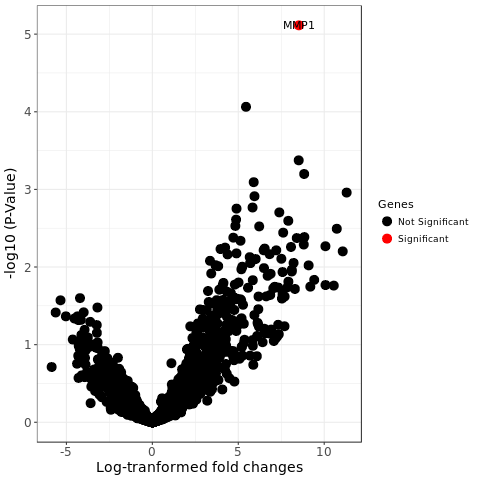

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7ce89ff560 / R:0x563c09cfdad0>
[ListVector, Environment, ListVector]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7ce89ff560 / R:0x563c09cfdad0>
[ListVector, Environment, ListVector]
  layout: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('Layout', 'ggproto') mapped to:
<Environment - Python:0x7f7ce89ffcb0 / R:0x563c02524248>
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7ce89ff560 / R:0x563c09cfdad0>
[ListVector, Environment, ListVector]

In [275]:
#customplot.volcano(sign['logFC'],-np.log10(sign['P.Value']),insign['logFC'],-np.log10(insign['P.Value']),name_sign='Significant genes',name_insign='Not significant genes',size=12,major_title='',xaxis='Log-transformed fold changes (logFC)',yaxis='- Log of P-value')
volcano_df=df_sign_up = pd.DataFrame({'logFC': limma_dataframe['logFC'],'adj.P.Val':limma_dataframe['adj.P.Val'],'p.Value':limma_dataframe['P.Value'],'gene':limma_dataframe.index,'AveExpr' : limma_dataframe['AveExpr']})

%Rpush volcano_df
%R library(ggplot2)
%R volcano_df<-as.data.frame(volcano_df)
%R Genes<-as.factor(abs(volcano_df$logFC) > 1.5 & volcano_df$adj.P.Val<0.1)
%R levels(Genes) <- sub("^TRUE$", "Significant",levels(Genes))
%R levels(Genes) <- sub("^FALSE$", "Not Significant",levels(Genes))
%R g <-ggplot(data=volcano_df, aes(x=logFC, y=-log10(p.Value))) + geom_point(aes(col=Genes),size=4) + scale_color_manual(values=c("black", "red"))+ theme(panel.background = element_blank())+geom_text(data=subset(volcano_df,abs(volcano_df$logFC)>1.5 & volcano_df$adj.P.Val<0.1),aes(label=gene)) + xlab('Log-tranformed fold changes') + ylab('-log10 (P-Value)') + theme_bw()+theme(axis.text=element_text(size=12),axis.title=element_text(size=14)) + guides(fill=guide_legend(title=NULL))
%R print(g)



#### Figure 3 | Volcano plots for the RNA-seq dataset.  
Volcano plot depicts the log of P-value for each gene verus log-transformed fold changes as compared to the control samples. The volcano plot shows the genes identified as significant (colored in red) and not significant (colored in blue). Limma method in R along with the thresholds (|logFC| > 1.5 and adjusted P-value < 0.1) were used to identify the significant genes.


### 3.2 MA Plot

MA plot depicts the log-transformed fold changes (M) for each gene versus its average expression (A). Fold changes and average expressions were calculated using limma package in R.


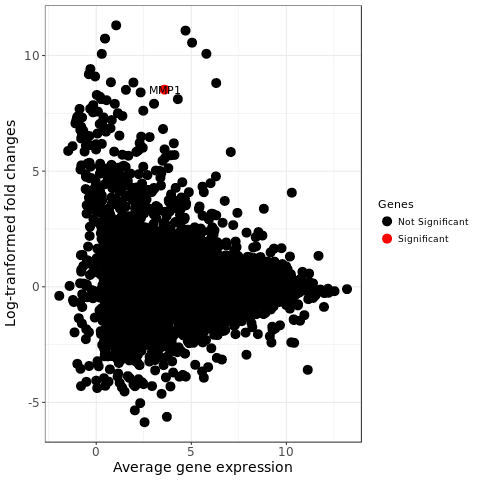

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7ce891a9e0 / R:0x563c077382c8>
[ListVector, Environment, ListVector]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7ce891a9e0 / R:0x563c077382c8>
[ListVector, Environment, ListVector]
  layout: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('Layout', 'ggproto') mapped to:
<Environment - Python:0x7f7cd85814d0 / R:0x563c0839a660>
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7ce891a9e0 / R:0x563c077382c8>
[ListVector, Environment, ListVector]

In [276]:
#customplot.volcano(sign['AveExpr'],sign['logFC'],x_insign1=insign['AveExpr'],y_insign1=insign['logFC'],name_sign='Significant genes',name_insign='Not significant genes',size=12,major_title='',xaxis='Average gene expression (A)',yaxis='Log-transformed fold changes-logFC (M)')
#customplot.volcano(sign['logFC'],-np.log10(sign['P.Value']),insign['logFC'],-np.log10(insign['P.Value']),name_sign='Significant genes',name_insign='Not significant genes',size=12,major_title='',xaxis='Log-transformed fold changes (logFC)',yaxis='- Log of P-value')
%Rpush volcano_df
%R library(ggplot2)
%R volcano_df<-as.data.frame(volcano_df)
%R Genes<-as.factor(abs(volcano_df$logFC) > 1.5 & volcano_df$adj.P.Val<0.1)
%R levels(Genes) <- sub("^TRUE$", "Significant",levels(criteria))
%R levels(Genes) <- sub("^FALSE$", "Not Significant",levels(Genes))
%R g <-ggplot(data=volcano_df, aes(x=AveExpr, y=logFC)) + geom_point(aes(col=Genes),size=4) + scale_color_manual(values=c("black", "red"))+ theme(panel.background = element_blank())+geom_text(data=subset(volcano_df,abs(volcano_df$logFC)>1.5 & volcano_df$adj.P.Val<0.1),aes(label=gene)) + xlab('Average gene expression') + ylab('Log-tranformed fold changes') + theme_bw()+theme(axis.text=element_text(size=12),axis.title=element_text(size=14)) + guides(fill=guide_legend(title=NULL))
%R print(g)



#### Figure 4 | MA plots for the RNA-seq dataset.  
MA plot depicts the log-transformed fold changes (M) for each gene versus average gene expression (A), calculated by limma package in R.The MA plot shows the genes identified as significant (colored in red) and not significant (colored in blue). Limma method in R along with the thresholds (|logFC| > 1.5 and adjusted P-value < 0.1) were used to identify the significant genes.


### 3.3 Further exploration of significant genes identified by limma

The following tables show significant upregulated genes and downregulated genes identifies by limma. You can scroll and search for genes of interest by using the toolbar in the tables.


In [277]:
list_sign_up=limma_dataframe[(limma_dataframe['logFC']>0) & (limma_dataframe['significant']==True)].index
list_sign_dn=limma_dataframe[(limma_dataframe['logFC']<0) & (limma_dataframe['significant']==True)].index

df_sign_up = pd.DataFrame({'Significant Upregulated Genes':list_sign_up, 'Log-transformed fold changes': limma_dataframe.loc[list_sign_up]['logFC'],'Adjusted P-value':limma_dataframe.loc[list_sign_up]['adj.P.Val']})
df_sign_up=df_sign_up[['Significant Upregulated Genes','Log-transformed fold changes','Adjusted P-value']]


df_sign_dn = pd.DataFrame({'Significant Downregulated Genes':list_sign_dn, 'Log-transformed fold changes': limma_dataframe.loc[list_sign_dn]['logFC'],'Adjusted P-value':limma_dataframe.loc[list_sign_dn]['adj.P.Val']})
df_sign_dn=df_sign_dn[['Significant Downregulated Genes','Log-transformed fold changes','Adjusted P-value']]

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(show_toolbar=True, remote_js=True,export_mode=True)       


In [278]:
df_sign_up.index=range(1,len(df_sign_up)+1)
qgrid.show_grid(df_sign_up) 


 #### Table 1 | Significant upregulated genes identified by limma as compared to control samples
The table shows the list of significant upregulated genes as compared to control samples. Limma method in R along with the thresholds (logFC > 1.5 and adjusted P-value < 0.1) were used to identify the significant genes.


In [279]:
df_sign_dn.index=range(1,len(df_sign_dn)+1)
qgrid.show_grid(df_sign_dn) 


 #### Table 2 | Significant downregulated genes identified by limma as compared to control samples
The table shows the list of significant downregulated genes as compared to control samples. Limma method in R along with the thresholds (logFC < -1.5 and adjusted P-value < 0.1) were used to identify the significant genes.


<a id='Gene Set Enrichment Analysis'></a>

## 4. Gene Set Enrichment Analysis

The differential gene expression signatures computed with limma are now used for enrichment analysis on top 500 upregulated and downregulated genes using [Enrichr](http://amp.pharm.mssm.edu/Enrichr/). 

[Enrichr](http://amp.pharm.mssm.edu/Enrichr/) is a comprehensive gene set enrichment analysis tool. Containing 180,184 annotated gene sets from 102 gene set libraries, it allows for easy and effective search and provides interactive visualizations of enrichment results <a href='#Citations'>[5]</a>. 



In [284]:
limma_up=limma_dataframe.loc[limma_dataframe['logFC']>=0]
limma_dn=limma_dataframe.loc[limma_dataframe['logFC']<0]
top_500=limma_up['adj.P.Val'].sort_values(ascending=True)[:500].index
bottom_500=limma_dn['adj.P.Val'].sort_values(ascending=True).tail(500).index

#top_500_var_indices=rawcount_dataframe.var(axis=1).sort_values(ascending=False)[:100].index
#top_500_var_genes=rawcount_dataframe.loc[top_500_var_indices]

#top_variable_genes=rawcount_dataframe_original.loc[rawcount_dataframe_original.apply(np.var,1).sort_values(ascending=False)[:5000].index]

#cd_dataframe=gene_signature.signature(top_variable_genes,method = 'CD',experimental_samples = experimental_samples, control_samples = control_samples)

#cd_dataframe.sort_values('CD',axis=0,ascending=False)[:200].index
#top_500=cd_dataframe.sort_values('CD',axis=0,ascending=False)[:200].index
#bottom_500=cd_dataframe.sort_values('CD',axis=0,ascending=False).tail(200).index




In [285]:

import upload_genesets
dict_up=upload_genesets.enrichr(top_500)[1]
dict_dn=upload_genesets.enrichr(bottom_500)[1]
user_list_id_up = dict_up.get('userListId')
user_list_id_dn=dict_dn.get('userListId')

import enrichr_library
#up_chea,dn_chea=enrichr_library.data(gene_set_library='ChEA_2016',user_list_id_up=user_list_id_up,user_list_id_dn=user_list_id_dn)
#up_bio_process,dn_bio_process=enrichr_library.data(gene_set_library='GO_Biological_Process_2017b',user_list_id_up=user_list_id_up,user_list_id_dn=user_list_id_dn)
#up_kegg,dn_kegg=enrichr_library.data(gene_set_library='KEGG_2016',user_list_id_up=user_list_id_up,user_list_id_dn=user_list_id_dn)

enrichr_url_up=upload_genesets.enrichr(top_500)[0]
enrichr_url_dn=upload_genesets.enrichr(bottom_500)[0]


In [286]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)
df = pd.DataFrame([enrichr_url_up,enrichr_url_dn])
df.index=['Upregulated genes','Downregulated genes']
df.columns=['Links to Enrichr results']
df.style.format(make_clickable)


,Links to Enrichr results
Upregulated genes,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=2qy8f
Downregulated genes,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=2qy8g


 #### Table 3 | Links to  Enrichr results
The table includes the links to  Enrichr results for top 500 upregulated and downregulated genes identified by CD method.


<a id='Small Molecule Predictions'></a>

 ### 5. Small Molecule Predictions

[L1000CDS<sup>2</sup>](http://amp.pharm.mssm.edu/L1000CDS2/#/index) is a state-of-the-art web-based search engine, which provides prioritization of thousands of small-molecule signatures, and their pairwise combination, predicted to either mimic or reverse an input gene expression signature <a href='#Citations'> [6]</a>. It integrates the library of intergrated network-based cellular signatures (LINCS) L1000 data set processed with [Characteristic Direction Method](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-79) <a href='#Citations'> [7]</a>.It currently includes information about more than a million gene expression profiles of chemically perturbed human cell lines. L1000CDS<sup>2</sup> was used to identify small molecules that would mimic or reverse the signature, using differential gene expression signatures computed using [Characteristic Direction Method](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-79).

A more detailed description of the library and CD method can be found in this publication: https://www.ncbi.nlm.nih.gov/pubmed/?term=28413689


In [283]:

import retrieve
smq_mimic=retrieve.small_molecule_query(top_500,bottom_500, mimic=True)[0]
smq_reverse=retrieve.small_molecule_query(top_500,bottom_500, mimic=False)[0]

df = pd.DataFrame([smq_mimic,smq_reverse])

df.index=['Small molecules predicted to mimic the signature','Small molecules predicted to reverse the signature']
df.columns=['Links to Small Molecule Query results']
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)
df.style.format(make_clickable)



,Links to Small Molecule Query results
Small molecules predicted to mimic the signature,http://amp.pharm.mssm.edu/L1000CDS2/#/result/59e5298ab09d47a600bd5ccc
Small molecules predicted to reverse the signature,http://amp.pharm.mssm.edu/L1000CDS2/#/result/59e5298ab09d47a600bd5cce


#### Table 4| Links to  Small Molecule Query results
The table includes the links to Small Molecule Query results. The resulting small molecules are reported, along with the cell line perturbed, dosage and time of exposure.


<a id='Citations'></a>

## Citations